# L4: Optimize DSPy Agent with DSPy Optimizer

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

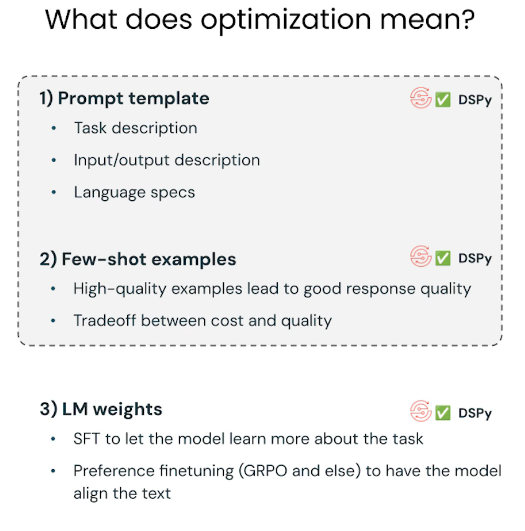

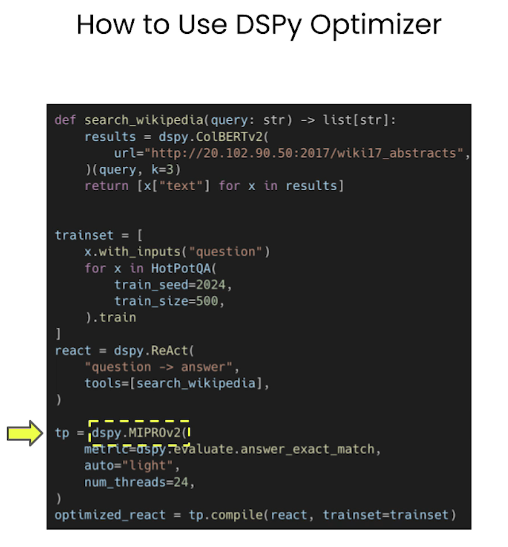

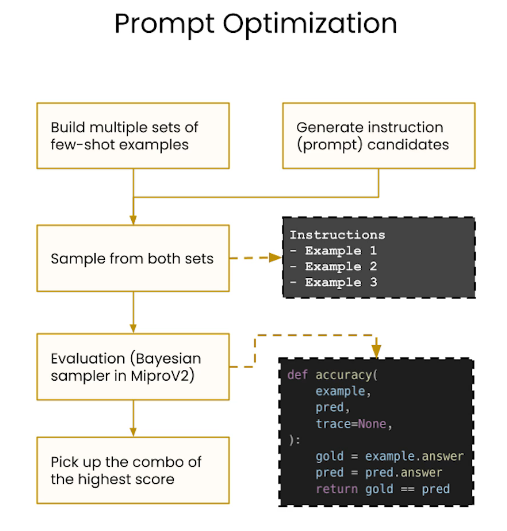

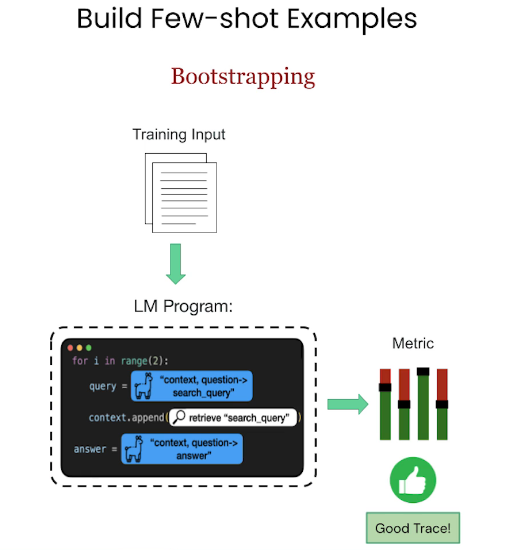

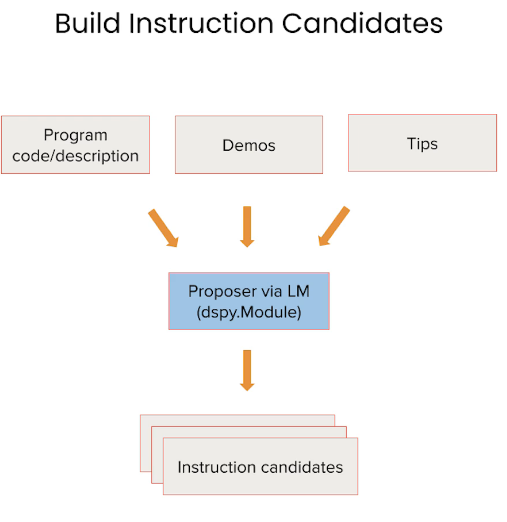

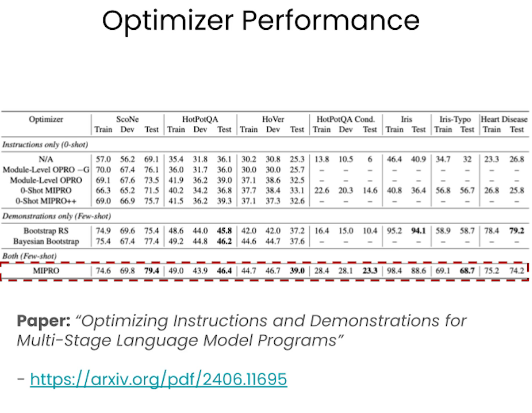

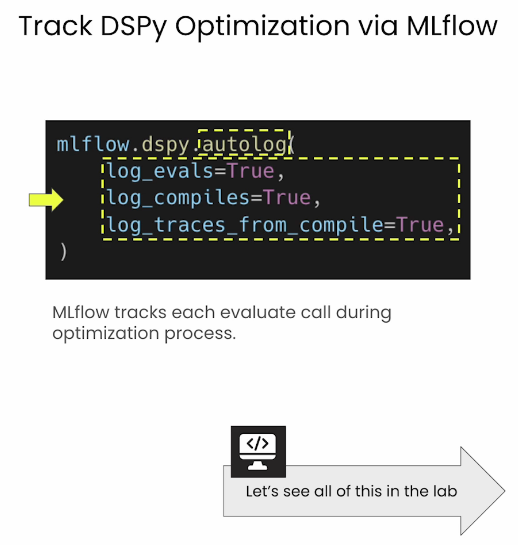

In [1]:
from helper import get_openai_api_key
openai_api_key = get_openai_api_key()

import os

os.environ["OPENAI_API_KEY"] = get_openai_api_key()

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.</p>

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>
</div>

In [2]:
import mlflow

In [3]:
from helper import get_mlflow_tracking_uri

mlflow_tracking_uri = get_mlflow_tracking_uri()
mlflow.set_tracking_uri(mlflow_tracking_uri)

In [4]:
mlflow.set_experiment("dspy_course_4")

2026/01/03 17:25:19 INFO mlflow.tracking.fluent: Experiment with name 'dspy_course_4' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/772237277845107473', creation_time=1767461119447, experiment_id='772237277845107473', last_update_time=1767461119447, lifecycle_stage='active', name='dspy_course_4', tags={}>

In [5]:
mlflow.dspy.autolog(log_evals=True, log_compiles=True, log_traces_from_compile=True)

In [6]:
import dspy

dspy.configure(lm=dspy.LM("openai/gpt-4o-mini"))

## Build a RAG Agent

In [7]:
def search_wikipedia(query: str) -> list[str]:
    results = dspy.ColBERTv2(url="http://20.102.90.50:2017/wiki17_abstracts")(query, k=3)
    return [x["text"] for x in results]

react = dspy.ReAct("question -> answer", tools=[search_wikipedia])

In [8]:
import json

# Load trainset
trainset = []
with open("trainset.jsonl", "r") as f:
    for line in f:
        trainset.append(dspy.Example(**json.loads(line)).with_inputs("question"))

# Load valset
valset = []
with open("valset.jsonl", "r") as f:
    for line in f:
        valset.append(dspy.Example(**json.loads(line)).with_inputs("question"))

In [9]:
# Overview of the dataset.
print(trainset[0])

Example({'question': 'Are Smyrnium and Nymania both types of plant?', 'answer': 'yes'}) (input_keys={'question'})


In [10]:
tp = dspy.MIPROv2(
    metric=dspy.evaluate.answer_exact_match,
    auto="light",
    num_threads=16
)

In [11]:
dspy.cache.load_memory_cache("./memory_cache.pkl")

In [12]:
optimized_react = tp.compile(
    react,
    trainset=trainset,
    valset=valset,
    requires_permission_to_run=False,
)

2026/01/03 17:25:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ba6846a002eb4035b78340bc87e61f90', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current dspy workflow
2026/01/03 17:25:21 INFO dspy.teleprompt.mipro_optimizer_v2: 
RUNNING WITH THE FOLLOWING LIGHT AUTO RUN SETTINGS:
num_trials: 20
minibatch: True
num_fewshot_candidates: 6
num_instruct_candidates: 3
valset size: 100

2026/01/03 17:25:21 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2026/01/03 17:25:21 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2026/01/03 17:25:21 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=6 sets of demonstrations...


Bootstrapping set 1/6
Bootstrapping set 2/6
Bootstrapping set 3/6


 18%|█▊        | 18/100 [00:01<00:06, 13.20it/s]


Bootstrapped 4 full traces after 18 examples for up to 1 rounds, amounting to 18 attempts.


Bootstrapping set 4/6


  1%|          | 1/100 [00:00<00:04, 19.94it/s]

Bootstrapped 1 full traces after 1 examples for up to 1 rounds, amounting to 1 attempts.


Bootstrapping set 5/6


 10%|█         | 10/100 [00:00<00:03, 25.90it/s]

Bootstrapped 4 full traces after 10 examples for up to 1 rounds, amounting to 10 attempts.


Bootstrapping set 6/6


  2%|▏         | 2/100 [00:00<00:04, 24.05it/s]

Bootstrapped 1 full traces after 2 examples for up to 1 rounds, amounting to 2 attempts.


2026/01/03 17:25:23 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2026/01/03 17:25:23 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2026/01/03 17:25:23 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=3 instructions...

2026/01/03 17:25:24 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2026/01/03 17:25:24 INFO dspy.teleprompt.mipro_optimizer_v2: 0: Given the fields `question`, produce the fields `answer`.

You are an Agent. In each episode, you will be given the fields `question` as input. And you can see your past trajectory so far.
Your goal is to use one or more of the supplied tools to collect any necessary information for producing `answer`.

To do this, you will interleave next_thought, next_tool_name, and next_tool_args in ea

Average Metric: 31.00 / 100 (31.0%): 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]

2026/01/03 17:25:27 INFO dspy.evaluate.evaluate: Average Metric: 31 / 100 (31.0%)
2026/01/03 17:25:27 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 31.0




🏃 View run eval_full_0 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/2d5e77287140498091dc776b61715405
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473


/usr/local/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2026/01/03 17:25:27 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 25 - Minibatch ==


Average Metric: 3.00 / 35 (8.6%): 100%|██████████| 35/35 [00:01<00:00, 27.50it/s] 

2026/01/03 17:25:28 INFO dspy.evaluate.evaluate: Average Metric: 3 / 35 (8.6%)
2026/01/03 17:25:28 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 8.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 0'].
2026/01/03 17:25:28 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57]
2026/01/03 17:25:28 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0]
2026/01/03 17:25:28 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 31.0
2026/01/03 17:25:28 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2026/01/03 17:25:28 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 25 - Minibatch ==



🏃 View run eval_minibatch_0 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/0f3e3faef7f0405493eb4205d2732f2d
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 18.00 / 35 (51.4%): 100%|██████████| 35/35 [00:01<00:00, 25.70it/s]

2026/01/03 17:25:30 INFO dspy.evaluate.evaluate: Average Metric: 18 / 35 (51.4%)
2026/01/03 17:25:30 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 51.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 2'].
2026/01/03 17:25:30 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43]
2026/01/03 17:25:30 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0]
2026/01/03 17:25:30 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 31.0
2026/01/03 17:25:30 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2026/01/03 17:25:30 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 25 - Minibatch ==



🏃 View run eval_minibatch_1 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/9e40929bb1314c4ebcc6e25b58458099
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 5.00 / 35 (14.3%): 100%|██████████| 35/35 [00:01<00:00, 26.71it/s]


2026/01/03 17:25:31 INFO dspy.evaluate.evaluate: Average Metric: 5 / 35 (14.3%)
2026/01/03 17:25:31 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 14.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 0'].
2026/01/03 17:25:31 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29]
2026/01/03 17:25:31 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0]
2026/01/03 17:25:31 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 31.0
2026/01/03 17:25:31 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2026/01/03 17:25:31 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 25 - Minibatch ==


🏃 View run eval_minibatch_2 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/aba80e4ad3fd426988a60805a5a129ae
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 19.00 / 35 (54.3%): 100%|██████████| 35/35 [00:01<00:00, 27.60it/s]

2026/01/03 17:25:33 INFO dspy.evaluate.evaluate: Average Metric: 19 / 35 (54.3%)
2026/01/03 17:25:33 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 54.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 4'].
2026/01/03 17:25:33 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29]
2026/01/03 17:25:33 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0]
2026/01/03 17:25:33 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 31.0
2026/01/03 17:25:33 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2026/01/03 17:25:33 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 25 - Minibatch ==



🏃 View run eval_minibatch_3 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/9284afcfbdd34888bfd4205f39a360d5
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 17.00 / 35 (48.6%): 100%|██████████| 35/35 [00:01<00:00, 19.65it/s]

2026/01/03 17:25:34 INFO dspy.evaluate.evaluate: Average Metric: 17 / 35 (48.6%)


2026/01/03 17:25:34 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 48.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 2'].
2026/01/03 17:25:34 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57]
2026/01/03 17:25:34 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0]
2026/01/03 17:25:34 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 31.0
2026/01/03 17:25:34 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2026/01/03 17:25:34 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 25 - Full Evaluation =====
2026/01/03 17:25:34 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 54.29) from minibatch trials...


🏃 View run eval_minibatch_4 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/f06319b2f94b4fae84e19f5507278d27
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 50.00 / 100 (50.0%): 100%|██████████| 100/100 [00:03<00:00, 26.19it/s]

2026/01/03 17:25:38 INFO dspy.evaluate.evaluate: Average Metric: 50 / 100 (50.0%)
2026/01/03 17:25:38 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 50.0
2026/01/03 17:25:38 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0]
2026/01/03 17:25:38 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:25:38 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2026/01/03 17:25:38 INFO dspy.teleprompt.mipro_optimizer_v2: 

2026/01/03 17:25:38 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 25 - Minibatch ==



🏃 View run eval_full_1 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/c3076c203e874f9fa8daafdb4216bc7e
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 15.00 / 35 (42.9%): 100%|██████████| 35/35 [00:01<00:00, 29.08it/s]

2026/01/03 17:25:39 INFO dspy.evaluate.evaluate: Average Metric: 15 / 35 (42.9%)
2026/01/03 17:25:40 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 42.86 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 0'].



🏃 View run eval_minibatch_5 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/41d2b6fea29b4bf2845507bb3f5be9eb
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473


2026/01/03 17:25:40 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86]
2026/01/03 17:25:40 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0]
2026/01/03 17:25:40 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:25:40 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2026/01/03 17:25:40 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 25 - Minibatch ==


Average Metric: 19.00 / 35 (54.3%): 100%|██████████| 35/35 [00:01<00:00, 25.14it/s]

2026/01/03 17:25:41 INFO dspy.evaluate.evaluate: Average Metric: 19 / 35 (54.3%)
2026/01/03 17:25:41 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 54.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 1'].
2026/01/03 17:25:41 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29]
2026/01/03 17:25:41 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0]
2026/01/03 17:25:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:25:41 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2026/01/03 17:25:41 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 25 - Minibatch ==



🏃 View run eval_minibatch_6 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/ba7b420a7f2b4685a5c95b945b250f28
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 6.00 / 35 (17.1%): 100%|██████████| 35/35 [00:01<00:00, 23.54it/s]

2026/01/03 17:25:42 INFO dspy.evaluate.evaluate: Average Metric: 6 / 35 (17.1%)



🏃 View run eval_minibatch_7 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/d2c0be152e3842f1a3945c2b130426d9
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473


2026/01/03 17:25:42 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 17.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 0', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 0'].
2026/01/03 17:25:42 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29, 17.14]
2026/01/03 17:25:42 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0]
2026/01/03 17:25:42 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:25:42 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2026/01/03 17:25:42 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 25 - Minibatch ==


Average Metric: 13.00 / 35 (37.1%): 100%|██████████| 35/35 [00:01<00:00, 25.07it/s]

2026/01/03 17:25:44 INFO dspy.evaluate.evaluate: Average Metric: 13 / 35 (37.1%)
2026/01/03 17:25:44 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 37.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 1', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 4'].
2026/01/03 17:25:44 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29, 17.14, 37.14]



🏃 View run eval_minibatch_8 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/4df5f3a2ee2946688e4d1d937e503b33
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473


2026/01/03 17:25:44 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0]
2026/01/03 17:25:44 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:25:44 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2026/01/03 17:25:44 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 25 - Minibatch ==


Average Metric: 19.00 / 35 (54.3%): 100%|██████████| 35/35 [00:01<00:00, 27.04it/s]

2026/01/03 17:25:45 INFO dspy.evaluate.evaluate: Average Metric: 19 / 35 (54.3%)


2026/01/03 17:25:45 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 54.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 4', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 1'].
2026/01/03 17:25:45 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29, 17.14, 37.14, 54.29]
2026/01/03 17:25:45 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0]
2026/01/03 17:25:45 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:25:45 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2026/01/03 17:25:45 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 25 - Full Evaluation =====
2026/01/03 17:25:45 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 54.29) from minibatch trials...


🏃 View run eval_minibatch_9 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/7879871706d94449b852790a7f9a1b91
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 49.00 / 100 (49.0%): 100%|██████████| 100/100 [00:04<00:00, 24.70it/s]

2026/01/03 17:25:49 INFO dspy.evaluate.evaluate: Average Metric: 49 / 100 (49.0%)
2026/01/03 17:25:49 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0, 49.0]
2026/01/03 17:25:49 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:25:49 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2026/01/03 17:25:49 INFO dspy.teleprompt.mipro_optimizer_v2: 

2026/01/03 17:25:49 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 14 / 25 - Minibatch ==



🏃 View run eval_full_2 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/3f7ce80a0a2a4268b3c73cbfd1837483
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 18.00 / 35 (51.4%): 100%|██████████| 35/35 [00:01<00:00, 25.01it/s]

2026/01/03 17:25:51 INFO dspy.evaluate.evaluate: Average Metric: 18 / 35 (51.4%)
2026/01/03 17:25:51 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 51.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 5', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 4'].
2026/01/03 17:25:51 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29, 17.14, 37.14, 54.29, 51.43]
2026/01/03 17:25:51 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0, 49.0]
2026/01/03 17:25:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:25:51 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2026/01/03 17:25:51 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 15 / 25 - Minibatch ==



🏃 View run eval_minibatch_10 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/444caa3dfd564dc1af8b32253b507337
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 18.00 / 35 (51.4%): 100%|██████████| 35/35 [00:01<00:00, 19.18it/s]

2026/01/03 17:25:53 INFO dspy.evaluate.evaluate: Average Metric: 18 / 35 (51.4%)


2026/01/03 17:25:53 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 51.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 1'].
2026/01/03 17:25:53 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29, 17.14, 37.14, 54.29, 51.43, 51.43]
2026/01/03 17:25:53 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0, 49.0]
2026/01/03 17:25:53 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:25:53 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2026/01/03 17:25:53 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 16 / 25 - Minibatch ==


🏃 View run eval_minibatch_11 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/fbd132c97f304167a4f6b0eaa88be4b9
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 19.00 / 35 (54.3%): 100%|██████████| 35/35 [00:01<00:00, 24.10it/s]

2026/01/03 17:25:54 INFO dspy.evaluate.evaluate: Average Metric: 19 / 35 (54.3%)



🏃 View run eval_minibatch_12 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/cb71f6bc83024dbcbab9be97c15626e2
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473


2026/01/03 17:25:54 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 54.29 on minibatch of size 35 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 4'].
2026/01/03 17:25:54 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29, 17.14, 37.14, 54.29, 51.43, 51.43, 54.29]
2026/01/03 17:25:54 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0, 49.0]
2026/01/03 17:25:54 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:25:54 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2026/01/03 17:25:54 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 17 / 25 - Minibatch ==


Average Metric: 17.00 / 35 (48.6%): 100%|██████████| 35/35 [00:01<00:00, 26.26it/s]

2026/01/03 17:25:56 INFO dspy.evaluate.evaluate: Average Metric: 17 / 35 (48.6%)
2026/01/03 17:25:56 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 48.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 3', 'Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 5'].
2026/01/03 17:25:56 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29, 17.14, 37.14, 54.29, 51.43, 51.43, 54.29, 48.57]
2026/01/03 17:25:56 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0, 49.0]
2026/01/03 17:25:56 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:25:56 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2026/01/03 17:25:56 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 18 / 25 - Minibatch ==



🏃 View run eval_minibatch_13 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/8e5724dec57a4709a9102bf5a0678d49
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 20.00 / 35 (57.1%): 100%|██████████| 35/35 [00:01<00:00, 26.62it/s]

2026/01/03 17:25:57 INFO dspy.evaluate.evaluate: Average Metric: 20 / 35 (57.1%)



🏃 View run eval_minibatch_14 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/978bd4a5830d4564839a350df9b7c375


2026/01/03 17:25:57 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 57.14 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 1'].
2026/01/03 17:25:57 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29, 17.14, 37.14, 54.29, 51.43, 51.43, 54.29, 48.57, 57.14]
2026/01/03 17:25:57 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0, 49.0]
2026/01/03 17:25:57 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:25:57 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2026/01/03 17:25:57 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 19 / 25 - Full Evaluation =====
2026/01/03 17:25:57 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 57.14) from minibatch trials...


🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 49.00 / 100 (49.0%): 100%|██████████| 100/100 [00:03<00:00, 25.44it/s]

2026/01/03 17:26:01 INFO dspy.evaluate.evaluate: Average Metric: 49 / 100 (49.0%)



🏃 View run eval_full_3 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/a6c5863a7b0241b3ba9f8c1920ae26b3
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473


2026/01/03 17:26:01 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0, 49.0, 49.0]
2026/01/03 17:26:01 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:26:01 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2026/01/03 17:26:01 INFO dspy.teleprompt.mipro_optimizer_v2: 

2026/01/03 17:26:01 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 20 / 25 - Minibatch ==


Average Metric: 17.00 / 35 (48.6%): 100%|██████████| 35/35 [00:01<00:00, 29.86it/s]

2026/01/03 17:26:02 INFO dspy.evaluate.evaluate: Average Metric: 17 / 35 (48.6%)


2026/01/03 17:26:02 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 48.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 1', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 1'].
2026/01/03 17:26:02 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29, 17.14, 37.14, 54.29, 51.43, 51.43, 54.29, 48.57, 57.14, 48.57]
2026/01/03 17:26:02 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0, 49.0, 49.0]
2026/01/03 17:26:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:26:02 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2026/01/03 17:26:02 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 21 / 25 - Minibatch ==


🏃 View run eval_minibatch_15 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/7932a25f32bb437cb361dfc327acd018
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 21.00 / 35 (60.0%): 100%|██████████| 35/35 [00:01<00:00, 18.79it/s]

2026/01/03 17:26:04 INFO dspy.evaluate.evaluate: Average Metric: 21 / 35 (60.0%)


2026/01/03 17:26:04 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 60.0 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 3'].
2026/01/03 17:26:04 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29, 17.14, 37.14, 54.29, 51.43, 51.43, 54.29, 48.57, 57.14, 48.57, 60.0]
2026/01/03 17:26:04 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0, 49.0, 49.0]
2026/01/03 17:26:04 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:26:04 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2026/01/03 17:26:04 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 22 / 25 - Minibatch ==


🏃 View run eval_minibatch_16 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/4517f74f92c949a5adc588821b098ba9
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 18.00 / 35 (51.4%): 100%|██████████| 35/35 [00:01<00:00, 24.42it/s]

2026/01/03 17:26:06 INFO dspy.evaluate.evaluate: Average Metric: 18 / 35 (51.4%)


2026/01/03 17:26:06 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 51.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 5'].
2026/01/03 17:26:06 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29, 17.14, 37.14, 54.29, 51.43, 51.43, 54.29, 48.57, 57.14, 48.57, 60.0, 51.43]
2026/01/03 17:26:06 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0, 49.0, 49.0]
2026/01/03 17:26:06 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:26:06 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2026/01/03 17:26:06 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 23 / 25 - Minibatch ==


🏃 View run eval_minibatch_17 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/b5bed08c62c74f0e811f5055a5b21da1
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 18.00 / 35 (51.4%): 100%|██████████| 35/35 [00:01<00:00, 24.89it/s]

2026/01/03 17:26:07 INFO dspy.evaluate.evaluate: Average Metric: 18 / 35 (51.4%)
2026/01/03 17:26:07 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 51.43 on minibatch of size 35 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 3'].
2026/01/03 17:26:07 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29, 17.14, 37.14, 54.29, 51.43, 51.43, 54.29, 48.57, 57.14, 48.57, 60.0, 51.43, 51.43]
2026/01/03 17:26:07 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0, 49.0, 49.0]
2026/01/03 17:26:07 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:26:07 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2026/01/03 17:26:07 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 24 / 25 - Minibatch ==



🏃 View run eval_minibatch_18 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/d46edb72dbf840d0ba53f1d2ed1746a1
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Average Metric: 17.00 / 35 (48.6%): 100%|██████████| 35/35 [00:01<00:00, 24.16it/s]

2026/01/03 17:26:09 INFO dspy.evaluate.evaluate: Average Metric: 17 / 35 (48.6%)



🏃 View run eval_minibatch_19 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/0689d1f630da4b978b682e598153a865
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473


2026/01/03 17:26:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 48.57 on minibatch of size 35 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 4', 'Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 3'].
2026/01/03 17:26:09 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: [8.57, 51.43, 14.29, 54.29, 48.57, 42.86, 54.29, 17.14, 37.14, 54.29, 51.43, 51.43, 54.29, 48.57, 57.14, 48.57, 60.0, 51.43, 51.43, 48.57]
2026/01/03 17:26:09 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0, 49.0, 49.0]
2026/01/03 17:26:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 50.0
2026/01/03 17:26:09 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2026/01/03 17:26:09 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 25 / 25 - Full Evaluation =====
2026/01/03 17:26:09 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 60.0) 

Average Metric: 54.00 / 100 (54.0%): 100%|██████████| 100/100 [00:04<00:00, 24.54it/s]

2026/01/03 17:26:13 INFO dspy.evaluate.evaluate: Average Metric: 54 / 100 (54.0%)



🏃 View run eval_full_4 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/7ae8034f72f543b5a124ae50b892de75
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473


2026/01/03 17:26:13 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 54.0
2026/01/03 17:26:13 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [31.0, 50.0, 49.0, 49.0, 54.0]
2026/01/03 17:26:13 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 54.0
2026/01/03 17:26:13 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2026/01/03 17:26:13 INFO dspy.teleprompt.mipro_optimizer_v2: 

2026/01/03 17:26:13 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 54.0!


🏃 View run kindly-eel-864 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/ba6846a002eb4035b78340bc87e61f90
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473


[Trace(request_id=65875cb63eb0444dae8e5cd88115cfed), Trace(request_id=f25c7d49e54c479aa9ac89e817fa1ab7), Trace(request_id=38047710b80348c986cc84c9f769c6d1), Trace(request_id=2e44cedb5f694fe48b48778295764f70), Trace(request_id=5d05cf54112e4fa99475d321c584de09), Trace(request_id=1e5e8aab1d8847208a1de48458fb670f), Trace(request_id=47e2aefba573491787d71d2c7610662c), Trace(request_id=ddfbc12668f4445a860121467802d73b), Trace(request_id=3b1d999fd0c04372b1e7e6c4ae8a0782), Trace(request_id=296379410f1d4f92995ae0dac8ea276d)]

In [13]:
optimized_react.react.signature

StringSignature(question, trajectory -> next_thought, next_tool_name, next_tool_args
    instructions="Given the fields `question`, produce the fields `answer`.\n\nYou are an Agent. In each episode, you will be given the fields `question` as input. And you can see your past trajectory so far.\nYour goal is to use one or more of the supplied tools to collect any necessary information for producing `answer`.\n\nTo do this, you will interleave next_thought, next_tool_name, and next_tool_args in each turn, and also when finishing the task.\nAfter each tool call, you receive a resulting observation, which gets appended to your trajectory.\n\nWhen writing next_thought, you may reason about the current situation and plan for future steps.\nWhen selecting the next_tool_name and its next_tool_args, the tool must be one of:\n\n(1) search_wikipedia. It takes arguments {'query': {'type': 'string'}} in JSON format.\n(2) finish, whose description is <desc>Marks the task as complete. That is, signals

In [14]:
optimized_react.react.demos

[Example({'augmented': True, 'question': 'That Darn Cat! and Never a Dull Moment were both produced by what studio?', 'trajectory': '[[ ## thought_0 ## ]]\nI need to find out which studio produced both "That Darn Cat!" and "Never a Dull Moment." This information is likely available on Wikipedia, so I will search for it there.\n\n[[ ## tool_name_0 ## ]]\nsearch_wikipedia\n\n[[ ## tool_args_0 ## ]]\n{"query": "That Darn Cat! and Never a Dull Moment studio production"}\n\n[[ ## observation_0 ## ]]\n[1] «That Darn Cat! | That Darn Cat! is a 1965 American Walt Disney Productions thriller comedy film starring Hayley Mills (in her last of the six films she made for the Walt Disney Studios) and Dean Jones (starring in his first film for Disney) in a story about bank robbers, a kidnapping and a mischievous cat. The film was based on the 1963 novel "Undercover Cat" by Gordon and Mildred Gordon and was directed by Robert Stevenson. The title song was written by the Sherman Brothers and sung by Bo

In [15]:
evaluator = dspy.Evaluate(
    metric=dspy.evaluate.answer_exact_match,
    devset=valset,
    display_table=True,
    display_progress=True,
    num_threads=24,
)

In [16]:
original_score = evaluator(react)
print(f"Original score: {original_score}")

Average Metric: 31.00 / 100 (31.0%): 100%|██████████| 100/100 [00:03<00:00, 26.07it/s]


2026/01/03 17:26:17 INFO dspy.evaluate.evaluate: Average Metric: 31 / 100 (31.0%)


,question,example_answer,trajectory,reasoning,pred_answer,answer_exact_match
0,"What movie did ""the king of cool"" play in with Bud Ekins as his st...","""The Great Escape""","{'thought_0': 'I need to find out which movie ""the king of cool"" s...","Steve McQueen, known as ""the king of cool,"" starred in the movie ""...","The movie is ""The Great Escape.""",
1,whos family had their own reality tv show. Robert Kardashian or Ma...,their family reality television series,"{'thought_0': 'I need to determine which individual, Robert Kardas...",Robert Kardashian's family is well-known for their reality TV show...,Robert Kardashian's family had their own reality TV show.,
2,Which star in Shadows in Paradise is a Russian ballerina?,Sofya Skya,"{'thought_0': 'I need to find out which star in the film ""Shadows ...","I searched for information about the cast of the 1986 film ""Shadow...",There is no information available about a Russian ballerina in the...,
3,What was the meaning of the name of the man who appointed Amashsai?,comforter,"{'thought_0': ""I need to find out who appointed Amashsai and the m...",Nehemiah appointed Amashsai to work at the temple in Jerusalem. Th...,"The meaning of the name of the man who appointed Amashsai, Nehemia...",
4,"In addition to the Austrian passport, what is needed to gain acces...",national identity card,{'thought_0': 'I need to find out what additional requirements or ...,To gain access to 173 countries and territories with an Austrian p...,"In addition to the Austrian passport, travelers may need to obtain...",
...,...,...,...,...,...,...
95,"What date did the American actress and singer-songwriter, known fo...","April 19, 1994",{'thought_0': 'I need to find out the name of the American actress...,The American actress and singer-songwriter known for her role as P...,2007,
96,What animated creatures were the title characters of the film whic...,seals,{'thought_0': 'I need to identify the animated creatures that were...,The animated creatures that are the title characters of the film b...,The animated creatures that are the title characters of the film b...,
97,The 1925 Saint Mary's Gaels football team represented what private...,Saint Mary's College of California,"{'thought_0': ""I need to find out which private, coeducational col...",The 1925 Saint Mary's Gaels football team represented Saint Mary's...,Saint Mary's College of California,✔️ [True]
98,Were Dorothy Arzner and Richard Wallace both French film directors?,no,{'thought_0': 'I need to verify the nationalities and contribution...,Both Dorothy Arzner and Richard Wallace were confirmed to be Ameri...,"No, neither Dorothy Arzner nor Richard Wallace were French film di...",


🏃 View run sincere-perch-84 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/5257095cbfad41d7a4fb779a62b3ddfd
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Original score: 31.0


[Trace(request_id=840e64155cb94353bf77531c9d14ee48), Trace(request_id=a4fe0d797c194f3ea27c9ed938bad928), Trace(request_id=68ff97e7fe684798942ed6dce9cd70d2), Trace(request_id=eac838908420437baf7bb64a3afbc007), Trace(request_id=1f0327adb8b247b2aadce4bdf6ab9067), Trace(request_id=def91a69de664ad29b4448f96e28dbdf), Trace(request_id=271cfadfe3ed415bab862b02a4be290f), Trace(request_id=d81b0899059743ca9a3bfcd4292181d3), Trace(request_id=7417d72d83c44b15bd1205b8de929549), Trace(request_id=4c9740dd3def42b49f783d5a61157a3f)]

In [17]:
optimized_score = evaluator(optimized_react)
print(f"Optimized score: {optimized_score}")

Average Metric: 54.00 / 100 (54.0%): 100%|██████████| 100/100 [00:04<00:00, 24.40it/s]

2026/01/03 17:26:21 INFO dspy.evaluate.evaluate: Average Metric: 54 / 100 (54.0%)


,question,example_answer,trajectory,reasoning,pred_answer,answer_exact_match
0,"What movie did ""the king of cool"" play in with Bud Ekins as his st...","""The Great Escape""","{'thought_0': 'I need to find out which movie ""the king of cool"" s...",I found that Bud Ekins was Steve McQueen's stunt double in the fil...,The Great Escape,✔️ [True]
1,whos family had their own reality tv show. Robert Kardashian or Ma...,their family reality television series,{'thought_0': 'I need to find out which family had their own reali...,"The Kardashian family, associated with Robert Kardashian, has thei...",Robert Kardashian,
2,Which star in Shadows in Paradise is a Russian ballerina?,Sofya Skya,"{'thought_0': 'I need to find out which star in ""Shadows in Paradi...","In my search for the cast of ""Shadows in Paradise,"" I found that t...",Sofya Skya,✔️ [True]
3,What was the meaning of the name of the man who appointed Amashsai?,comforter,"{'thought_0': ""I need to find out who appointed Amashsai and the m...","Amashsai was appointed by Nehemiah, and the name Amasai, which is ...","""Burdensome""",
4,"In addition to the Austrian passport, what is needed to gain acces...",national identity card,{'thought_0': 'I need to find out what additional requirements are...,The search results indicate that Austrian citizens have visa-free ...,"A valid Austrian passport, and potentially a visa or health docume...",
...,...,...,...,...,...,...
95,"What date did the American actress and singer-songwriter, known fo...","April 19, 1994",{'thought_0': 'I need to find out the release date of the first al...,I found that the American actress and singer-songwriter Katey Saga...,"April 19, 1994",✔️ [True]
96,What animated creatures were the title characters of the film whic...,seals,{'thought_0': 'I need to identify the animated creatures that were...,The question pertains to animated creatures that are the title cha...,"Fairies (specifically Puck, Titania, and Oberon)",
97,The 1925 Saint Mary's Gaels football team represented what private...,Saint Mary's College of California,"{'thought_0': ""I need to find out which private, coeducational col...",The 1925 Saint Mary's Gaels football team represented Saint Mary's...,Saint Mary's College of California,✔️ [True]
98,Were Dorothy Arzner and Richard Wallace both French film directors?,no,"{'thought_0': ""I need to determine if both Dorothy Arzner and Rich...","I found that Dorothy Arzner was an American film director, and Ric...","No, neither Dorothy Arzner nor Richard Wallace were French film di...",


🏃 View run painted-gnat-97 at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473/runs/2f0bc2f16637431ca6cb86a8bb8cfaef
🧪 View experiment at: https://s172-29-50-3p8080.lab-aws-production.deeplearning.ai//#/experiments/772237277845107473
Optimized score: 54.0


[Trace(request_id=6eaafadcbd524d7db7896697c2579ee7), Trace(request_id=409d397c1e484cb486a05fcecafc6691), Trace(request_id=508e6a6f75564d13ade63c85574b72ad), Trace(request_id=fc90e1f11b7a4a3798be3212dac91a3e), Trace(request_id=f05e9f8a099e4037bd2b2aa8bc5f42c8), Trace(request_id=86ee2893d252499eb08fae9d04935a6a), Trace(request_id=95b6b8b7d12d491cad89e13c2bd942b0), Trace(request_id=793fa015bd5949fa96a1f5259687aab4), Trace(request_id=a0051b0f21d843d981088aee3e459697), Trace(request_id=0cdcad7b64364311b2629624ba6ead49)]